<a href="https://colab.research.google.com/github/Camicb/Projects/blob/main/Travel_Insurance_Claim_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Travel Insurance Claim Prediction**

#1. Introduction

Many companies selling tickets or travel packages, give consumers the option to purchase travel insurance, also known as travelers insurance. Travel insurance is a type of insurance that covers the costs and losses associated with traveling. It is useful protection for those traveling domestically or abroad.
Some travel policies cover damage to personal property, rented equipment, such as rental cars, or even the cost of paying a ransom. 

The objective of this project is to create a machine learning model for a insurance company to predict if the insurance buyer will claim their travel insurance or not.

This project was part of an assignment for a Machine Learning Bootcamp conducted by [DPhi](https://dphi.tech/) last year. The datasets were provided freely by them.

#2. Import Required Libraries

In [ ]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
#!pip install pycaret -q
!pip install scikit-plot -q
!pip install -U imbalanced-learn -q
!pip install delayed -q
!pip install -U yellowbrick
!pip install shap

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn import set_config
from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

Colab mode enabled.


In [2]:
np.random.seed(2021) # A seed for reproducibility

#3. Exploratory Data Analysis
##3.1 About the data
There are 11 columns in the dataset:
*   **Duration:** Travel duration
*   **Destination:** Travel destination (country)
*   **Agency:** Agency Name
*   **Agency Type:** Travel Agency or Airlines 
*   **Commission (in value):** Commission on the insurance
*   **Age:** Age of the insurance buyer
*   **Gender:** Gender of the insurance buyer
*   **Distribution Channel:** offline/online
*   **Product Name:** Name of the insurance plan
*   **Net Sales:** Net sales
*   **Claim:** If the insurance is claimed or not (the target variable), 0 = not claimed, 1 = claimed


In [3]:
# Load the provided data into a pandas data frame 
ins = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" ) # training data
test_ins = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv') # testing data

## 3.2 Exploratory data analysis

In [5]:
ins.head()
print(' ')
ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,NaN,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,NaN,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,NaN,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,M,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,NaN,23,0


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [6]:
test_ins.head()
print(' ')
test_ins.info()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                15832 non-null  object 
 1   Agency Type           15832 non-null  object 
 2   Distribution Channel  15832 non-null  object 
 3   Product Name          15832 non-null  object 
 4   Duration              15832 non-null  int64  
 5   Destination           15832 non-null  object 
 6   Net Sales             15832 non-null  float64
 7   Commision (in value)  15832 non-null  float64
 8   Gender                4546 non-null   object 
 9   Age                   15832 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [7]:
# Statistic report
profile = ProfileReport(ins, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

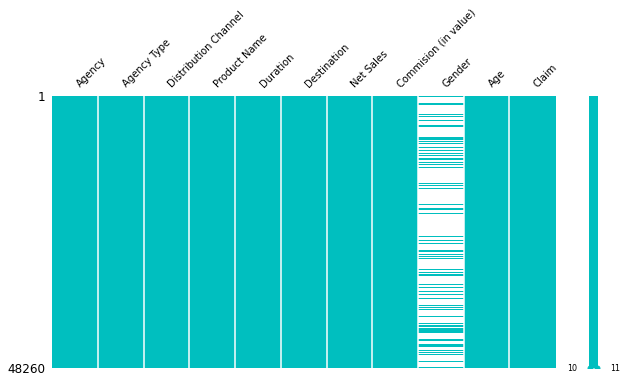

In [8]:
# Visualization of missing values 
msno.matrix(ins, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75)) 

# 4. Preprocessing

Changes in the testing data are executed in order to maintain a consistent shape with the training data. Since 'Gender' has too many missing values and the 'Distribution Channel' is highly correlated to others variables and presents imbalanced classes, the entire columns will be removed. Outliers will be removed too.

In [4]:
# Droping irrelevants columns
ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)
test_ins.drop(['Gender', 'Distribution Channel'], axis=1, inplace=True)

In [5]:
# Transforming outliers into NaN for posterior imputation
ins['Duration']= ins.loc[:, 'Duration'].apply(lambda x: np.nan if x < 1 else x)
ins['Age']= ins.loc[:,'Age'].apply(lambda x: np.nan if x == 118 else x)

In [6]:
# Checking the shape of the data for modeling
ins.shape
test_ins.shape

(48260, 9)

(15832, 8)

# 5. Modeling experiments
  
I will use a python library called Pycaret to perform preprocessing to the data and to compare possible models to adress this problem. I will experiment with different models that will include techniques such as clustering, dimensionality reduction, oversampling the target variable, etc.  Missing values will be imputed with the mean or the most frequent value, categorical variables will be one-hot encoded, and the data will be normalized with z-score. The actual training data will be split into a new training (80% data) and validation (20%) datasets. From each comparison I will choose the top scoring classifier.

Then, I will choose a model and create a pipeline with sklearn for the preprocessing and classification components. I will also tried a simple neural network to make comparisons.

## 5.1 Modeling with Pycaret

###5.1.1 Modeling with dimensionality reduction ([Boruta](https://github.com/scikit-learn-contrib/boruta_py)), and a stratify split


In [19]:
# Setting up enviroment 

clf_1=setup(ins, target = 'Claim',
          train_size = 0.80,
          categorical_imputation = 'mode',
          normalize = True,
          normalize_method = 'zscore',
          feature_selection=True, 
          feature_selection_method='boruta',
          data_split_stratify=True,
          n_jobs=-1, 
          session_id=1)

,Description,Value
0,session_id,123
1,Target,Claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(48260, 9)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [22]:
#Comparing classifiers 
compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9651,0.8255,0.2176,0.1198,0.1543,0.1380,0.1446,0.242
qda,Quadratic Discriminant Analysis,0.8131,0.6211,0.4232,0.0495,0.0789,0.0550,0.0898,0.119
dt,Decision Tree Classifier,0.9713,0.5387,0.0777,0.0678,0.0719,0.0574,0.0578,0.137
et,Extra Trees Classifier,0.9813,0.6664,0.0407,0.1119,0.0594,0.0522,0.0592,1.991
rf,Random Forest Classifier,0.9839,0.7049,0.0336,0.2094,0.0560,0.0522,0.0748,2.076
nb,Naive Bayes,0.4438,0.7957,0.8798,0.0227,0.0443,0.0162,0.0770,0.054
knn,K Neighbors Classifier,0.9847,0.5987,0.0070,0.0950,0.0131,0.0115,0.0228,1.024
lightgbm,Light Gradient Boosting Machine,0.9849,0.8173,0.0053,0.3000,0.0104,0.0093,0.0374,0.363
lr,Logistic Regression,0.9853,0.8244,0.0000,0.0000,0.0000,0.0000,0.0000,0.451
svm,SVM - Linear Kernel,0.9853,0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0003,0.093


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [23]:
# Creating a model 
cl1 = create_model('lda', verbose=False)

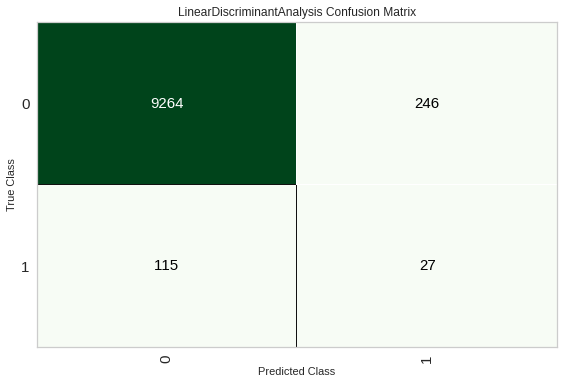

In [24]:
# Analizing the model through plots
plot_model(cl1, plot = 'confusion_matrix')

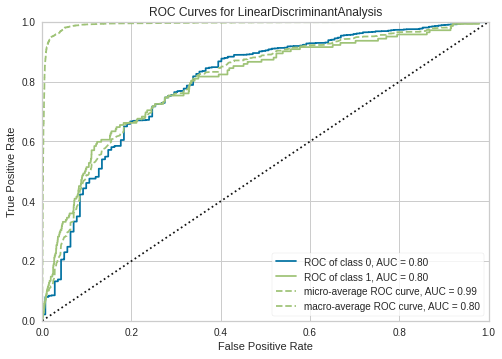

In [25]:
plot_model(cl1, plot = 'auc')

###5.1.2 Modeling with dimensionality reduction (PCA) and a stratify split

In [10]:
# Setting up enviroment 

clf_2=setup(ins, target = 'Claim',
          train_size = 0.80,
          categorical_imputation = 'mode',
          normalize = True,
          normalize_method = 'zscore',
          pca = True, 
          pca_method = 'linear',
          data_split_stratify=True,
          n_jobs=-1, 
          session_id=2)

,Description,Value
0,session_id,123
1,Target,Claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(48260, 9)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
# Comparing classifiers 
compare_models(sort='F1', exclude=['dt', 'rf', 'ada', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9662,0.8214,0.2087,0.1216,0.1533,0.1374,0.1427,0.487
nb,Naive Bayes,0.8410,0.7641,0.6467,0.0582,0.1067,0.0820,0.1596,0.053
et,Extra Trees Classifier,0.9804,0.6835,0.0495,0.1130,0.0684,0.0601,0.0655,2.700
qda,Quadratic Discriminant Analysis,0.6729,0.7794,0.7950,0.0350,0.0670,0.0400,0.1192,0.145
lightgbm,Light Gradient Boosting Machine,0.9848,0.8086,0.0176,0.2744,0.0322,0.0302,0.0612,1.287
knn,K Neighbors Classifier,0.9846,0.5976,0.0070,0.0950,0.0131,0.0114,0.0226,0.864
lr,Logistic Regression,0.9853,0.8218,0.0000,0.0000,0.0000,0.0000,0.0000,0.615
svm,SVM - Linear Kernel,0.9853,0.0000,0.0000,0.0000,0.0000,-0.0001,-0.0003,0.102
ridge,Ridge Classifier,0.9853,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.054


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [14]:
# Creating a model 
cl2 = create_model('lda', verbose=False)

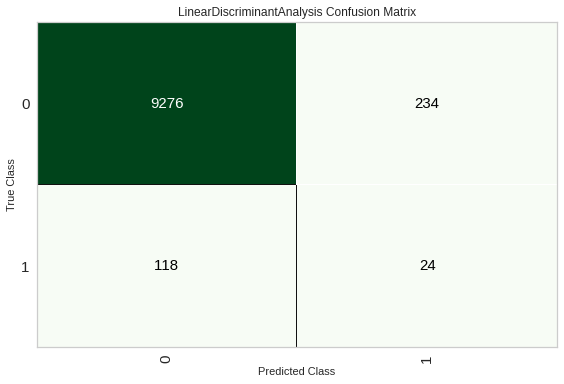

In [15]:
# Analizing the model through plots
plot_model(cl2, plot = 'confusion_matrix')

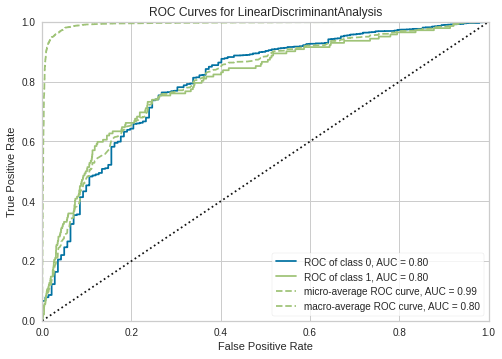

In [16]:
plot_model(cl2, plot = 'auc')

###5.1.3 Modeling with clustering, PCA and oversampling with SMOTE

In [30]:
# Setting up enviroment 

clf_3 = setup(ins, target = 'Claim',
          train_size = 0.80,
          categorical_imputation = 'mode',
          normalize = True,
          normalize_method = 'zscore',
          pca = True, 
          pca_method = 'linear', 
          ignore_low_variance = True,
          data_split_stratify=True,
          fix_imbalance = True,
          n_jobs=-1, 
          session_id=4)

,Description,Value
0,session_id,4
1,Target,Claim
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(48260, 9)"
5,Missing Values,True
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,True


In [31]:
# Comparing classifiers 
compare_models(sort='F1')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.8282,0.7453,0.6325,0.0528,0.0974,0.0723,0.1464,0.052
nb,Naive Bayes,0.8204,0.7543,0.6378,0.0509,0.0943,0.0690,0.1431,0.048
gbc,Gradient Boosting Classifier,0.8034,0.8042,0.6659,0.0484,0.0903,0.0647,0.1412,11.376
rf,Random Forest Classifier,0.9286,0.7181,0.2367,0.0546,0.0887,0.0665,0.0866,12.314
lightgbm,Light Gradient Boosting Machine,0.8197,0.7786,0.5882,0.0472,0.0874,0.0619,0.1280,0.542
ada,Ada Boost Classifier,0.7857,0.8047,0.6907,0.0461,0.0864,0.0606,0.1387,2.634
lr,Logistic Regression,0.7760,0.7809,0.6872,0.0439,0.0826,0.0566,0.1328,0.341
ridge,Ridge Classifier,0.7702,0.0000,0.6924,0.0432,0.0813,0.0552,0.1315,0.049
lda,Linear Discriminant Analysis,0.7703,0.7769,0.6924,0.0432,0.0813,0.0553,0.1315,0.096
et,Extra Trees Classifier,0.9323,0.6905,0.2014,0.0501,0.0802,0.0581,0.0738,3.791


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [32]:
# Creating a model 
cl3 = create_model('qda', verbose=False)

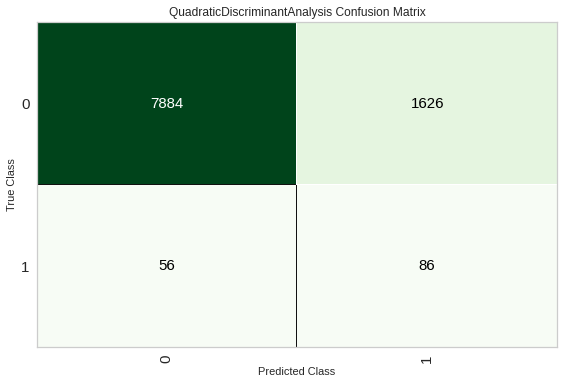

In [33]:
# Analizing the model through plots
plot_model(cl3, plot = 'confusion_matrix')

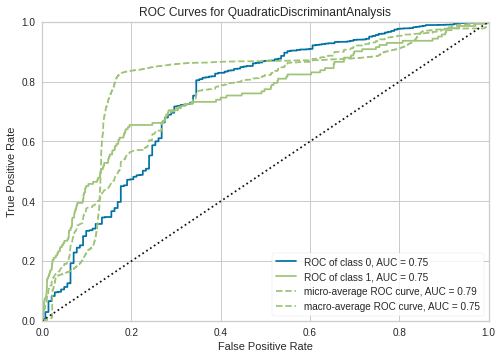

In [34]:
plot_model(cl3, plot = 'auc')

So apparently, between all the classifiers, the Linear Discriminant Analysis with PCA is the better option. Naive Bayes also performed well.

## 5.2 Modeling with scikit-learn

In [ ]:
# Spliting data into training, validation and test datasets

X = bank.drop(['subscribed', 'duration'], axis=1)
y = bank['subscribed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
clf = QuadraticDiscriminantAnalysis()


# 6. Predictions

In [ ]:
#predict_model(svm) # on validation data

In [ ]:
# Make Prediction on Test Dataset
#predictions=predict_model(lightGBM, data=test_ins)
#target=predictions['Label']

#res = pd.DataFrame(target) 
#res.index = test_ins.index 
#res.columns = ["prediction"]

# To download the csv file locally
#from google.colab import files
#res.to_csv('submission.csv', index=False)         
#files.download('submission.csv')


The score obtained by uploading the submission at the Dphi website is 11.428571428571429. Top score in the leaderboard is 16.176470588235293. So I guess my results are not bad considering I didn't adjust hyperparameters or changed the data and models too much.

In [ ]:
#Final model parameters for deployment
#final_svm = finalize_model(svm)
#print(final_svm)